<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Загрузка-изображений-и-подготовка-датасета" data-toc-modified-id="Загрузка-изображений-и-подготовка-датасета-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Загрузка изображений и подготовка датасета</a></span></li><li><span><a href="#Анализ-изображений" data-toc-modified-id="Анализ-изображений-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ изображений</a></span></li><li><span><a href="#Подготовка-модели-CNN" data-toc-modified-id="Подготовка-модели-CNN-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Подготовка модели CNN</a></span></li><li><span><a href="#Обучение-модели-CNN" data-toc-modified-id="Обучение-модели-CNN-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели CNN</a></span></li><li><span><a href="#Предсказание-на-тестовой-выборке" data-toc-modified-id="Предсказание-на-тестовой-выборке-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Предсказание на тестовой выборке</a></span></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

# Тема: Классификация изображений

Нам предстоить помочь телекомпании FOX в обработке их контента. Как все знают, сериал «Симпсоны» идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. 

**Цель:** 
- необходимо классифицировать персонажей, проживающих в Спрингфилде.

**Описание датасета**

Тренировочная и тестовая выборки состоят из отрывков из мультсериала Симпсоны. Каждая картинка представлена в формате `jpg` c необходимой меткой — названием персонажа изображенного на ней. Тест был поделен на приватную и публичную часть в соотношении 95/5.

В тренировочном датасете примерно по 1000 картинок на каждый класс, но они отличаются размером.

## Загрузка изображений и подготовка датасета

In [1]:
import os
import pickle
import zipfile
import numpy as np
import pandas as pd
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm, trange

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score

random_seed = 42
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

sns.set_style("darkgrid")
%matplotlib inline

In [2]:
try:
    os.mkdir('./springfield')
except FileExistsError:
    print('Папка springfield уже существует')
    
with zipfile.ZipFile('journey-springfield.zip', 'r') as zip_obj:
    zip_obj.extractall('./springfield')

print('After zip extraction:')
print(os.listdir('./springfield'))

Папка springfield уже существует
After zip extraction:
['characters_illustration.png', 'sample_submission.csv', 'testset', 'train']


In [3]:
TRAIN_DIR = Path('./springfield/train/simpsons_dataset')
TEST_DIR = Path('./springfield/testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224

In [4]:
class SimpsonsDataset(Dataset):

    def __init__(self, files, mode):
        super().__init__()
        self.files = sorted(files)
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f'{self.mode} is not correct; correct modes: {DATA_MODES}')
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        transformation = {'train':transforms.Compose([transforms.ToTensor(),
                                                      transforms.Resize([224, 224]),
                                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                      transforms.GaussianBlur(3),
                                                      transforms.RandomRotation(degrees=(0, 20)),
                                                      transforms.RandomHorizontalFlip(p=0.5)]),
            
                          'test': transforms.Compose([transforms.ToTensor(),
                                                      transforms.Resize([224, 224]),
                                                      transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])}
        
        
        x = self.load_sample(self.files[index])
        
        if self.mode == 'test':
            return transformation['test'](x)
        
        elif self.mode == 'train':
            x = transformation['train'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
        else:
            x = transformation['test'](x)
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.2, stratify=train_val_labels)


train_dataset = SimpsonsDataset(train_files, mode='train')
val_dataset = SimpsonsDataset(val_files, mode='val')
test_dataset = SimpsonsDataset(test_files, mode='test')

## Анализ изображений

Изначальное количество изображений каждого персонажа в тренировочном датасете

In [6]:
simpsons = pd.Series(train_val_labels).value_counts().sort_values(ascending=False).to_frame('number_of_images')
simpsons.style.background_gradient('coolwarm')

,number_of_images
homer_simpson,2246
ned_flanders,1454
moe_szyslak,1452
lisa_simpson,1354
bart_simpson,1342
marge_simpson,1291
krusty_the_clown,1206
principal_skinner,1194
charles_montgomery_burns,1193
milhouse_van_houten,1079


In [7]:
train_labels = [path.parent.name for path in train_files]
val_labels = [path.parent.name for path in val_files]
simpsons_train = pd.Series(train_labels).value_counts().sort_values(ascending=False).to_frame('number_of_images')
simpsons_val = pd.Series(val_labels).value_counts().sort_values(ascending=False).to_frame('number_of_images')

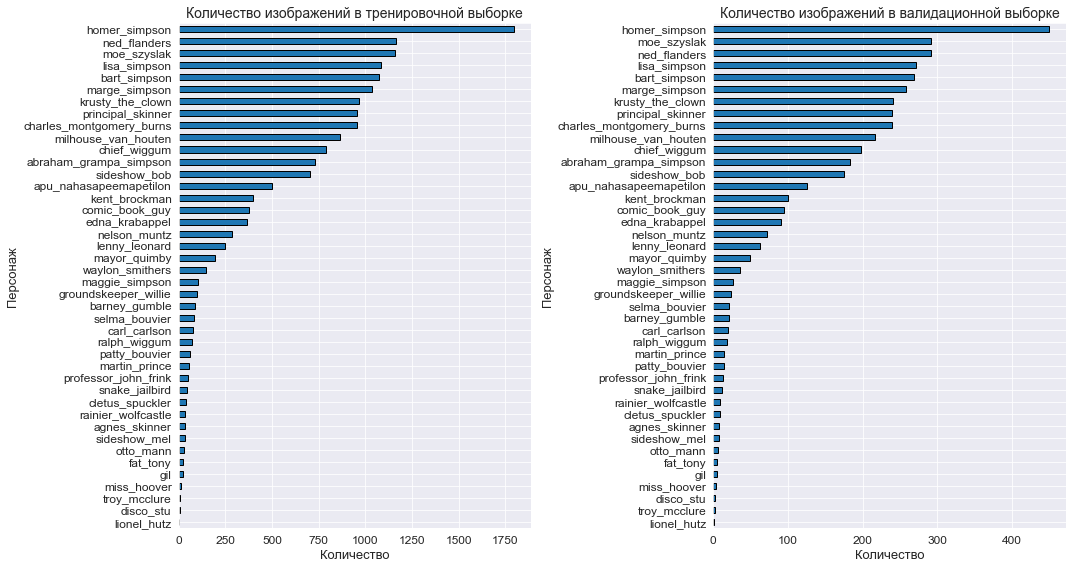

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))

ax = simpsons_train.sort_values(by='number_of_images').plot(kind='barh', 
                                                            figsize=(15, 8), 
                                                            ec='black', 
                                                            legend=False, 
                                                            fontsize=12,
                                                            ax=axes[0])

ax.set_title('Количество изображений в тренировочной выборке', fontsize=14)
ax.set_xlabel('Количество', fontsize=13)
ax.set_ylabel('Персонаж', fontsize=13);

ax = simpsons_val.sort_values(by='number_of_images').plot(kind='barh', 
                                                          figsize=(15, 8), 
                                                          ec='black', 
                                                          legend=False, 
                                                          fontsize=12,
                                                          ax=axes[1])

ax.set_title('Количество изображений в валидационной выборке', fontsize=14)
ax.set_xlabel('Количество', fontsize=13)
ax.set_ylabel('Персонаж', fontsize=13)
plt.tight_layout();

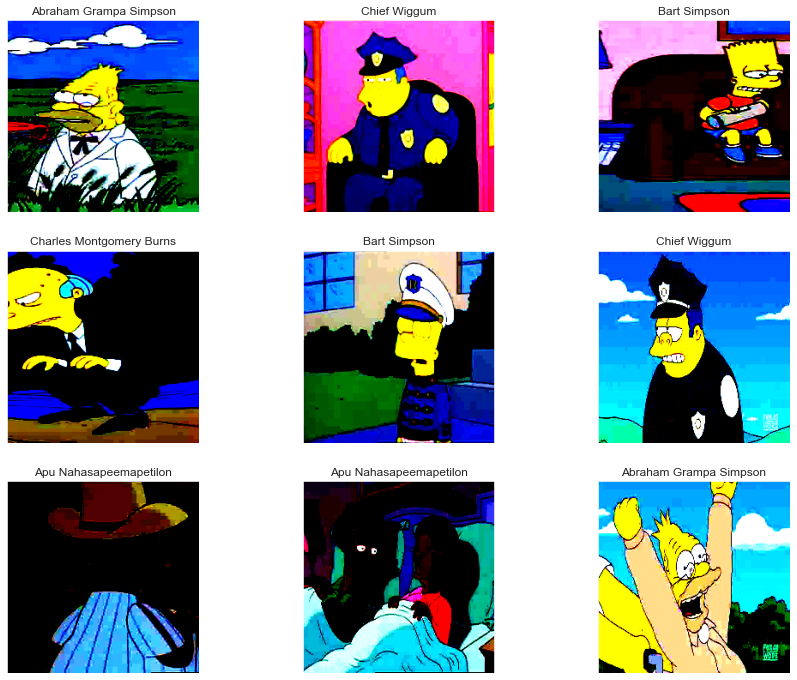

In [9]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(15, 12), sharey=True, sharex=True)

for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0, 1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(), val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    fig_x.imshow(im_val.data.cpu().permute(1, 2, 0).clip(0, 1))
    fig_x.set_title(img_label)
    fig_x.set_xticks([])
    fig_x.set_yticks([])

**Выводы:**
- Выборка изображений не сбалансированна.
- Проведено стратифицированное разбиение на тренировочную и валидационую части.

## Подготовка модели CNN

In [10]:
model = models.resnet152(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

for param in model.layer4.parameters():
    param.requires_grad = True
    
model.fc = torch.nn.Linear(model.fc.in_features, out_features=len(np.unique(train_val_labels)))

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1.0e-4)

scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.1)

In [11]:
def train_model(model, train_dataset, val_dataset, loss_function, optimizer, scheduler, batch_size=16, epoch=5):
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    dataloaders = {'train': train_loader, 'val': val_loader}
    
    loss_history = {'train': [], 'val': []}
    f1_history = {'train': [], 'val': []}
    best_f1 = 0
    
    pbar = trange(epoch, desc='Epoch')
    
    for n, epoch in enumerate(pbar):
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0
            running_f1 = 0
            n_iter = 0
            
            for batch in tqdm(dataloaders[phase], leave=False, desc = f'{"Training" if phase == "train" else "Validation"}'):
                x_batch, y_batch = batch
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                    
                if phase == 'train':
                    optimizer.zero_grad()
                    output = model(x_batch)
                else:
                    with torch.no_grad():
                        output = model(x_batch)
                        
                preds = torch.argmax(output, 1)
                loss = loss_function(output, y_batch)
                f1 = f1_score(y_batch.cpu(), preds.cpu(), average='micro')
                
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                        
                running_loss += loss.item()
                running_f1 += f1.item()
                n_iter += 1
                
            epoch_loss = running_loss/n_iter
            epoch_f1 = running_f1/n_iter   
            loss_history[phase].append(epoch_loss)
            f1_history[phase].append(epoch_f1)
                
            print(f'Epoch {n+1} - {phase} F1-score: {round(epoch_f1, 2)} {phase} Loss: {round(epoch_loss, 2)}')
            
            if phase == 'val' and epoch_f1 > best_f1:
                best_f1 = epoch_f1
                model_weights = model.state_dict()
                
        scheduler.step()
            
    print(f'best F1 score is {best_f1}')
    model.load_state_dict(model_weights)
        
    return model, loss_history, f1_history

## Обучение модели CNN

In [12]:
model_result, loss_results, f1_results = train_model(model, train_dataset, val_dataset, loss_function, 
                                                     optimizer, scheduler, batch_size=128, epoch=10)

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 1 - train F1-score: 0.73 train Loss: 1.2


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 1 - val F1-score: 0.89 val Loss: 0.49


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 2 - train F1-score: 0.92 train Loss: 0.34


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 2 - val F1-score: 0.92 val Loss: 0.32


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 3 - train F1-score: 0.96 train Loss: 0.18


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 3 - val F1-score: 0.95 val Loss: 0.21


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 4 - train F1-score: 0.97 train Loss: 0.11


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 4 - val F1-score: 0.95 val Loss: 0.19


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 5 - train F1-score: 0.99 train Loss: 0.07


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 5 - val F1-score: 0.96 val Loss: 0.16


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 6 - train F1-score: 0.99 train Loss: 0.06


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 6 - val F1-score: 0.96 val Loss: 0.15


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 7 - train F1-score: 0.99 train Loss: 0.05


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 7 - val F1-score: 0.96 val Loss: 0.15


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 8 - train F1-score: 0.99 train Loss: 0.05


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 8 - val F1-score: 0.97 val Loss: 0.14


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 9 - train F1-score: 0.99 train Loss: 0.04


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 9 - val F1-score: 0.97 val Loss: 0.14


Training:   0%|          | 0/131 [00:00<?, ?it/s]

Epoch 10 - train F1-score: 0.99 train Loss: 0.04


Validation:   0%|          | 0/33 [00:00<?, ?it/s]

Epoch 10 - val F1-score: 0.97 val Loss: 0.14
best F1 score is 0.9656125124875125


In [13]:
torch.save(model_result.state_dict(), './resnet152.pth')

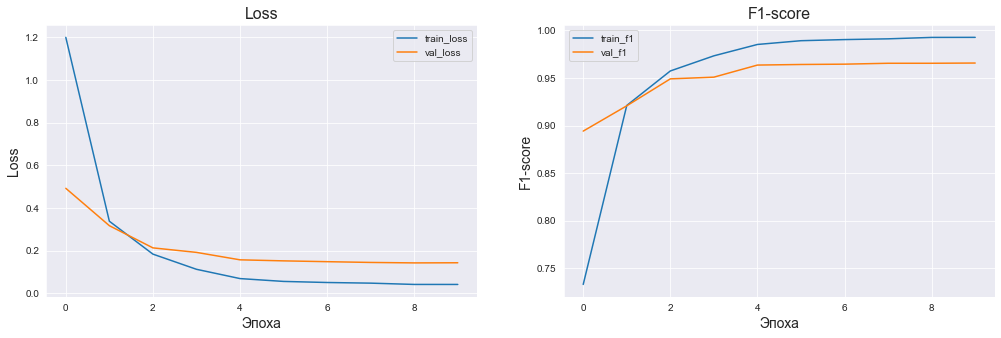

In [14]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
ax[0].plot(loss_results['train'], label="train_loss")
ax[0].plot(loss_results['val'], label="val_loss")
ax[0].set_title('Loss', fontsize=16)
ax[0].set_xlabel('Эпоха', fontsize=14)
ax[0].set_ylabel('Loss', fontsize=14)
ax[0].legend(loc='best')

ax[1].plot(f1_results['train'], label="train_f1")
ax[1].plot(f1_results['val'], label="val_f1")
ax[1].set_title('F1-score', fontsize=16)
ax[1].set_xlabel('Эпоха', fontsize=14)
ax[1].set_ylabel('F1-score', fontsize=14)
ax[1].legend(loc='best');

**Выводы:**
- F1-score на валидационной выборке: 0.97

## Предсказание на тестовой выборке

In [15]:
def predict(model):
    model.to(device)
    test_loader = DataLoader(test_dataset, shuffle=False, batch_size=128)
    logits = []
    model.eval()
    
    for batch in tqdm(test_loader, leave=False):
        batch = batch.to(device)
        with torch.no_grad(): 
            outputs = model(batch).cpu()
            probs = nn.functional.softmax(outputs, dim=-1)
        logits.append(probs)
             
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [16]:
predictions = predict(model_result)
label_encoder = pickle.load(open("./label_encoder.pkl", 'rb'))
predictions = label_encoder.inverse_transform(np.argmax(predictions, 1))
test_filenames = [path.name for path in test_dataset.files]

  0%|          | 0/8 [00:00<?, ?it/s]

In [17]:
submission = pd.DataFrame({'Id': test_filenames, 'Expected': predictions})
submission.to_csv('./submission.csv', index=False)

## Вывод

**Public Score на Kaggle:**
- F1-score: 0.99256